# 时供水量预测
使用前 24 小时的数据预测下 24 小时供水流量，当时天气数据已知

In [1]:
import math
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Source Han Sans SC'

## 导入数据集

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.drop(df.columns[0], axis=1, inplace=True)

In [3]:
df

,合计流量,最低温,最高温,降水概率,日期类型,日正弦,日余弦
0,9549.526855,19.8,26.4,0.7,0.0,-8.660254e-01,-5.000000e-01
1,7504.327271,19.8,26.4,0.7,0.0,-9.659258e-01,-2.588190e-01
2,6786.833496,19.8,26.4,0.7,0.0,-1.000000e+00,-1.117943e-11
3,7356.773926,19.8,26.4,0.7,0.0,-9.659258e-01,2.588190e-01
4,6612.100830,19.8,26.4,0.7,0.0,-8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...
1267,16440.752441,22.9,24.6,0.7,1.0,2.588190e-01,-9.659258e-01
1268,18479.248291,22.9,24.6,0.7,1.0,-9.277308e-13,-1.000000e+00
1269,19219.998535,22.9,24.6,0.7,1.0,-2.588190e-01,-9.659258e-01
1270,15527.785645,22.9,24.6,0.7,1.0,-5.000000e-01,-8.660254e-01


### 分割数据

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 规范化数据

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

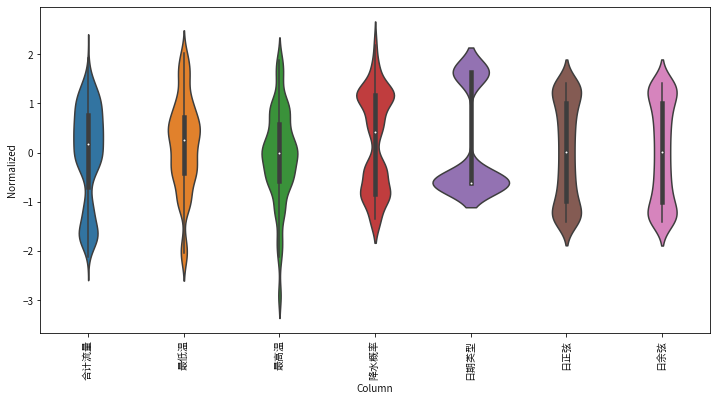

In [6]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口

### 索引和偏移

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

 

In [8]:
w1 = WindowGenerator(input_width=4, label_width=2, shift=0,
                     label_columns=['合计流量'])

In [9]:
w1

Total window size: 4
Input indices: [0 1 2 3]
Label indices: [2 3]
Label column name(s): ['合计流量']

In [10]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
 # Stack three slices, the length of the total window: batch_size = 3
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
 

All shapes are: (batch, time, features)
Window shape: (3, 4, 7)
Inputs shape: (3, 4, 7)
labels shape: (3, 2, 1)


In [12]:
example_inputs

<tf.Tensor: shape=(3, 4, 7), dtype=float64, numpy=
array([[[-1.12854949e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.22021637e+00,
         -7.06046893e-01],
        [-1.65794149e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.36130987e+00,
         -3.64895029e-01],
        [-1.84366198e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.40943423e+00,
          1.20601566e-03],
        [-1.69613510e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.36130987e+00,
          3.67307061e-01]],

       [[-1.91206390e+00,  7.30256099e-01, -3.12910032e-01,
         -8.52352435e-01, -6.10767694e-01, -1.22021637e+00,
          7.08458924e-01],
        [-1.22208622e+00,  7.30256099e-01, -3.12910032e-01,
         -8.52352435e-01, -6.10767694e-01, -9.95769028e-01,
          1.00141267e+00],
        [-2.80822038e-01,  7.30256099e-01, -3.12910032e-01,
     

In [13]:
example_labels

<tf.Tensor: shape=(3, 2, 1), dtype=float64, numpy=
array([[[-1.84366198],
        [-1.6961351 ]],

       [[-0.28082204],
        [ 1.19075581]],

       [[ 0.95354096],
        [ 0.47269074]]])>

### 绘图

In [14]:
def make_dataset(self, data, shuffle=True, batch_size=32):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  return next(iter(self.test))

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
 

In [16]:
def plot(self, model=None, plot_col='合计流量', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
 

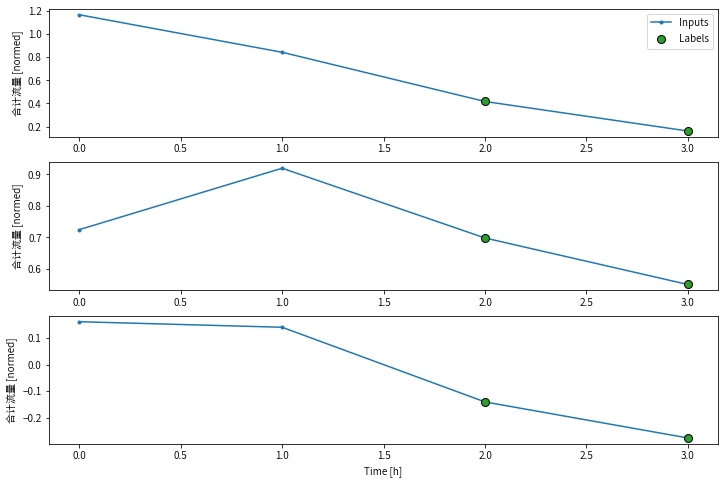

In [17]:
w1.plot()

## LSTM 多步骤模型

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['合计流量']

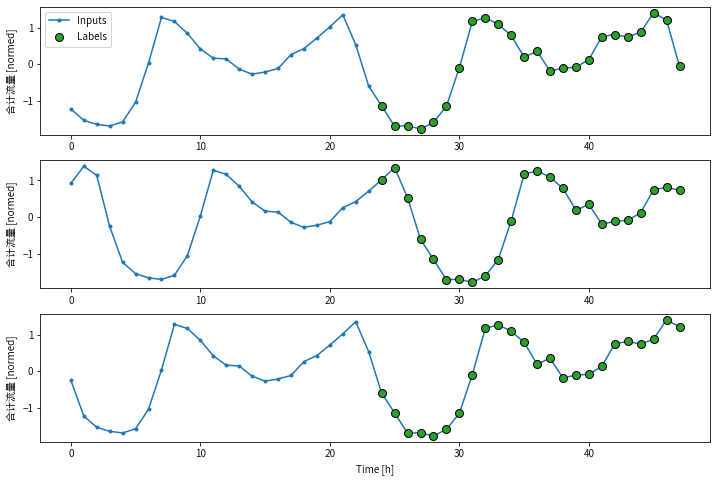

In [18]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=48,
                               label_width=OUT_STEPS,
                               shift=0,
                               label_columns=['合计流量'])

multi_window.plot()
multi_window

In [19]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 48, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [20]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 48, 7)
Labels shape (batch, time, features): (32, 24, 1)


### 基准线

In [21]:
multi_val_performance = {}
multi_performance = {}

7/7 [==============================] - 0s 1ms/step - loss: 0.1186 - mean_absolute_error: 0.2638


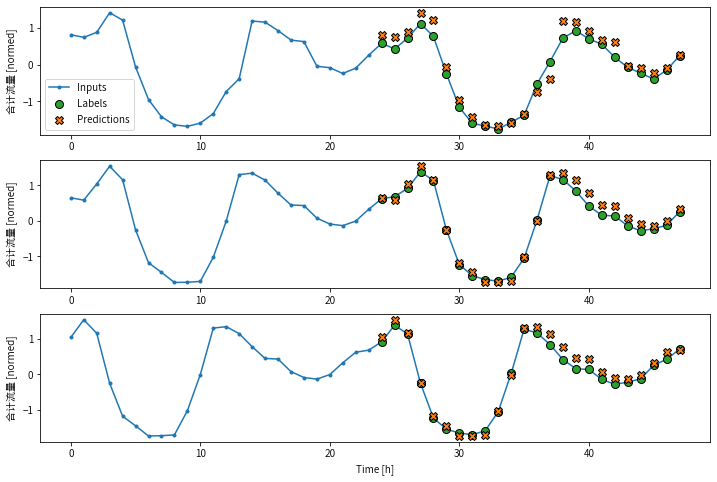

In [22]:
class RepeatBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    result = inputs[:, :OUT_STEPS, self.label_index]
    return result[:, :, tf.newaxis]

repeat_baseline = RepeatBaseline(label_index=column_indices['合计流量'])
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)
 

### LSTM

In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [24]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(1)

In [25]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [26]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [27]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # 第一次调用预热
  prediction, state = self.warmup(inputs[:, :OUT_STEPS, :])
  
  # 加入 list
  predictions.append(prediction)

  # 剩余步骤预测
  for n in range(1, self.out_steps):
    # 用预测的供水量数据替换真实数据中的供水量
    x = inputs[:, OUT_STEPS+n-1, 1:]
    x = tf.concat([prediction, x], axis=1)
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [28]:
print('Input shape (batch, time, features: ', multi_window.example[0].shape)
print('Output shape (batch, time, features: ', multi_window.example[1].shape)
print('Predict shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Input shape (batch, time, features:  (32, 48, 7)
Output shape (batch, time, features:  (32, 24, 1)
Predict shape (batch, time, features):  (32, 24, 1)


In [29]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/20
27/27 [==============================] - 1s 42ms/step - loss: 0.7199 - mean_absolute_error: 0.7057 - val_loss: 0.5779 - val_mean_absolute_error: 0.6511
Epoch 2/20
27/27 [==============================] - 0s 18ms/step - loss: 0.4192 - mean_absolute_error: 0.5418 - val_loss: 0.3201 - val_mean_absolute_error: 0.4742
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1694 - mean_absolute_error: 0.3296 - val_loss: 0.1641 - val_mean_absolute_error: 0.3279
Epoch 4/20
27/27 [==============================] - 0s 13ms/step - loss: 0.0795 - mean_absolute_error: 0.2165 - val_loss: 0.1147 - val_mean_absolute_error: 0.2663
Epoch 5/20
27/27 [==============================] - 0s 13ms/step - loss: 0.0532 - mean_absolute_error: 0.1766 - val_loss: 0.1026 - val_mean_absolute_error: 0.2478
Epoch 6/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0426 - mean_absolute_error: 0.1568 - val_loss: 0.0974 - val_mean_absolute_error: 0.2388
Epoch 7/20
27/27 [====

In [30]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

7/7 [==============================] - 0s 4ms/step - loss: 0.0937 - mean_absolute_error: 0.2389


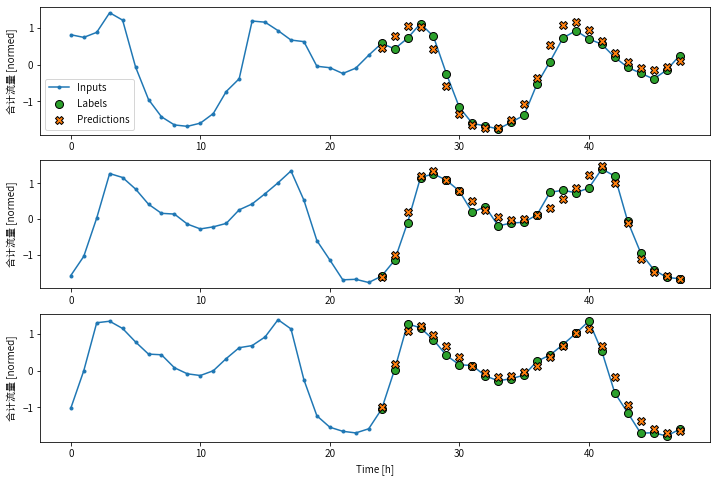

In [31]:
multi_window.plot(feedback_model, max_subplots=3)

In [32]:
print(multi_val_performance)
print(multi_performance)

{'Repeat': [0.11856601387262344, 0.263805091381073], 'AR LSTM': [0.09370055794715881, 0.23885317146778107]}
{'Repeat': [0.09183312952518463, 0.21021270751953125], 'AR LSTM': [0.046668268740177155, 0.15777084231376648]}


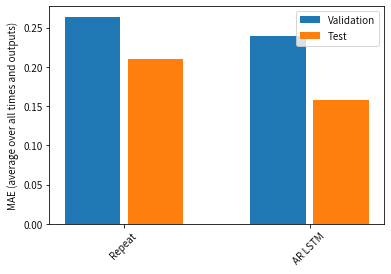

In [33]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()